<a href="https://colab.research.google.com/github/Shah-zam9/DVLM_Assignment0/blob/main/Task3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
%%writefile architecture.py
import torch
import torch.nn as nn
import torch.nn.functional as F

class VAE(nn.Module):
    def __init__(self, latent_dim=20):
        super(VAE, self).__init__()
        self.enc_conv1 = nn.Conv2d(1, 32, 4, stride=2, padding=1)
        self.enc_conv2 = nn.Conv2d(32, 64, 4, stride=2, padding=1)
        self.enc_fc = nn.Linear(64*7*7, 256)
        self.fc_mu = nn.Linear(256, latent_dim)
        self.fc_logvar = nn.Linear(256, latent_dim)

        self.dec_fc = nn.Linear(latent_dim, 256)
        self.dec_fc2 = nn.Linear(256, 64*7*7)
        self.dec_deconv1 = nn.ConvTranspose2d(64, 32, 4, stride=2, padding=1)
        self.dec_deconv2 = nn.ConvTranspose2d(32, 1, 4, stride=2, padding=1)

    def encode(self, x):
        x = F.relu(self.enc_conv1(x))
        x = F.relu(self.enc_conv2(x))
        x = x.view(x.size(0), -1)
        h = F.relu(self.enc_fc(x))
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

    def decode(self, z):
        h = F.relu(self.dec_fc(z))
        h = F.relu(self.dec_fc2(h))
        h = h.view(-1, 64, 7, 7)
        h = F.relu(self.dec_deconv1(h))
        x_recon = torch.sigmoid(self.dec_deconv2(h))
        return x_recon

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

Overwriting architecture.py


Starting Phase 1: Baseline Training...
Epoch 1: Total Loss: 38.1 | KLD: 6.0652
Epoch 2: Total Loss: 27.0 | KLD: 6.8942
Epoch 3: Total Loss: 25.6 | KLD: 7.1752
Epoch 4: Total Loss: 24.9 | KLD: 7.4071
Epoch 5: Total Loss: 24.5 | KLD: 7.5001
Epoch 6: Total Loss: 24.2 | KLD: 7.6004
Epoch 7: Total Loss: 24.0 | KLD: 7.6387
Epoch 8: Total Loss: 23.8 | KLD: 7.6783
Epoch 9: Total Loss: 23.7 | KLD: 7.7359
Epoch 10: Total Loss: 23.6 | KLD: 7.7746


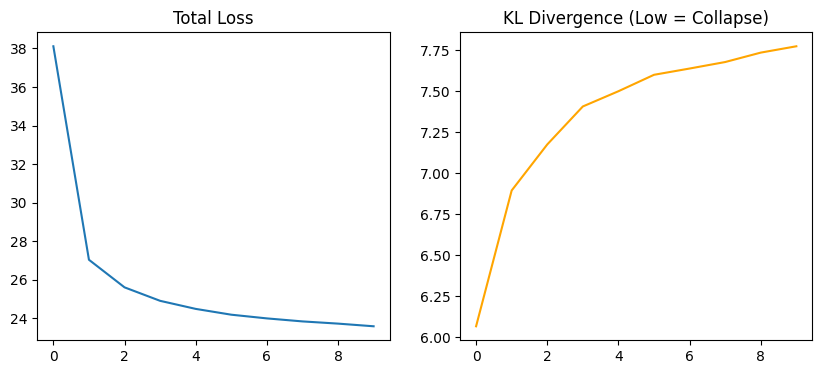

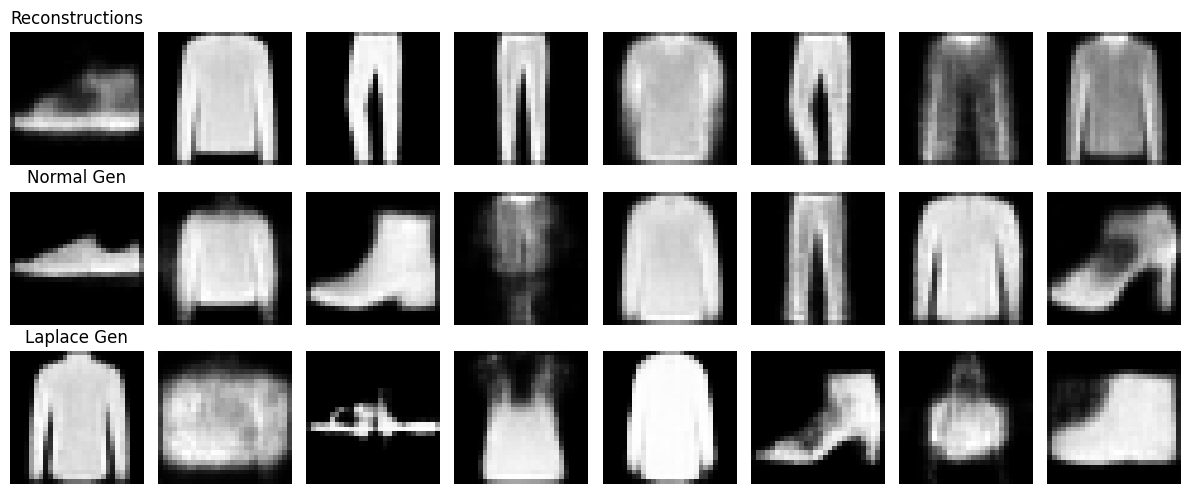

Final KLD: 7.7746


In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torch.distributions import Laplace
import matplotlib.pyplot as plt


class VAE(nn.Module):
    def __init__(self, latent_dim=20):
        super(VAE, self).__init__()
        self.enc_conv1 = nn.Conv2d(1, 32, 4, stride=2, padding=1)
        self.enc_conv2 = nn.Conv2d(32, 64, 4, stride=2, padding=1)
        self.enc_fc = nn.Linear(64*7*7, 256)
        self.fc_mu = nn.Linear(256, latent_dim)
        self.fc_logvar = nn.Linear(256, latent_dim)

        self.dec_fc = nn.Linear(latent_dim, 256)
        self.dec_fc2 = nn.Linear(256, 64*7*7)
        self.dec_deconv1 = nn.ConvTranspose2d(64, 32, 4, stride=2, padding=1)
        self.dec_deconv2 = nn.ConvTranspose2d(32, 1, 4, stride=2, padding=1)

    def encode(self, x):
        x = F.relu(self.enc_conv1(x))
        x = F.relu(self.enc_conv2(x))
        x = x.view(x.size(0), -1)
        h = F.relu(self.enc_fc(x))
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

    def decode(self, z):
        h = F.relu(self.dec_fc(z))
        h = F.relu(self.dec_fc2(h))
        h = h.view(-1, 64, 7, 7)
        h = F.relu(self.dec_deconv1(h))
        x_recon = torch.sigmoid(self.dec_deconv2(h))
        return x_recon

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

device = "cuda" if torch.cuda.is_available() else "cpu"
batch_size = 128
epochs = 10

train_loader = DataLoader(
    datasets.FashionMNIST('./data', train=True, download=True, transform=transforms.ToTensor()),
    batch_size=batch_size, shuffle=True)
test_loader = DataLoader(
    datasets.FashionMNIST('./data', train=False, transform=transforms.ToTensor()),
    batch_size=batch_size, shuffle=False)

model = VAE(latent_dim=20).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

print("Starting Phase 1: Baseline Training...")
train_losses = []
kl_losses = []

for epoch in range(1, epochs + 1):
    model.train()
    total_loss = 0
    total_kld = 0

    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()

        recon_batch, mu, logvar = model(data)

        MSE = F.mse_loss(recon_batch, data, reduction='sum')
        KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

        loss = MSE + KLD
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        total_kld += KLD.item()

    avg_loss = total_loss / len(train_loader.dataset)
    avg_kld = total_kld / len(train_loader.dataset)
    train_losses.append(avg_loss)
    kl_losses.append(avg_kld)

    print(f'Epoch {epoch}: Total Loss: {avg_loss:.1f} | KLD: {avg_kld:.4f}')

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Total Loss')
plt.title("Total Loss")
plt.subplot(1, 2, 2)
plt.plot(kl_losses, color='orange', label='KL Divergence')
plt.title("KL Divergence (Low = Collapse)")
plt.savefig("vae_baseline_losses.png")
plt.show()

model.eval()
with torch.no_grad():
    data, _ = next(iter(test_loader))
    data = data.to(device)
    recon, _, _ = model(data)

    z_norm = torch.randn(8, 20).to(device)
    gen_norm = model.decode(z_norm)

    m = Laplace(torch.tensor([0.0]), torch.tensor([1.0]))
    z_lap = m.sample((8, 20)).squeeze().to(device)
    gen_lap = model.decode(z_lap)

fig, ax = plt.subplots(3, 8, figsize=(12, 5))
for i in range(8):
    ax[0,i].imshow(recon[i].cpu().squeeze(), cmap='gray'); ax[0,i].axis('off')
    ax[1,i].imshow(gen_norm[i].cpu().squeeze(), cmap='gray'); ax[1,i].axis('off')
    ax[2,i].imshow(gen_lap[i].cpu().squeeze(), cmap='gray'); ax[2,i].axis('off')
ax[0,0].set_title("Reconstructions")
ax[1,0].set_title("Normal Gen")
ax[2,0].set_title("Laplace Gen")
plt.tight_layout()
plt.savefig("vae_baseline_visuals.png")
plt.show()

print(f"Final KLD: {kl_losses[-1]:.4f}")


Starting Phase 2: Training with KL Annealing...
Epoch 1: Beta: 0.00 | KLD: 289.1576
Epoch 2: Beta: 0.20 | KLD: 24.0466
Epoch 3: Beta: 0.40 | KLD: 15.5804
Epoch 4: Beta: 0.60 | KLD: 12.2262
Epoch 5: Beta: 0.80 | KLD: 10.2339
Epoch 6: Beta: 1.00 | KLD: 8.9719
Epoch 7: Beta: 1.00 | KLD: 8.7822
Epoch 8: Beta: 1.00 | KLD: 8.6941
Epoch 9: Beta: 1.00 | KLD: 8.6682
Epoch 10: Beta: 1.00 | KLD: 8.6029


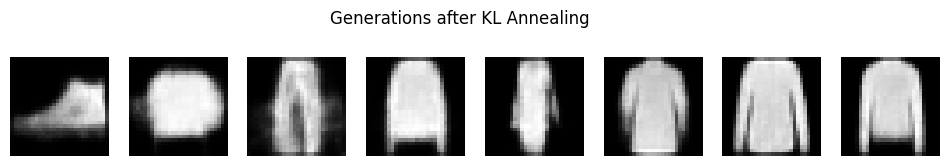

Task 3 Complete.


In [6]:
print("\nStarting Phase 2: Training with KL Annealing...")

model_annealed = VAE(latent_dim=20).to(device)
optimizer = optim.Adam(model_annealed.parameters(), lr=1e-3)
annealed_kl = []

def get_beta(epoch):
    return min(1.0, (epoch - 1) / 5.0)

for epoch in range(1, epochs + 1):
    model_annealed.train()
    total_kld = 0
    beta = get_beta(epoch)

    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar = model_annealed(data)

        MSE = F.mse_loss(recon_batch, data, reduction='sum')
        KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

        loss = MSE + (beta * KLD)
        loss.backward()
        optimizer.step()
        total_kld += KLD.item()

    avg_kld = total_kld / len(train_loader.dataset)
    annealed_kl.append(avg_kld)
    print(f'Epoch {epoch}: Beta: {beta:.2f} | KLD: {avg_kld:.4f}')

model_annealed.eval()
with torch.no_grad():
    z = torch.randn(8, 20).to(device)
    gen_fixed = model_annealed.decode(z)

fig, ax = plt.subplots(1, 8, figsize=(12, 2))
for i in range(8):
    ax[i].imshow(gen_fixed[i].cpu().squeeze(), cmap='gray'); ax[i].axis('off')
plt.suptitle("Generations after KL Annealing")
plt.savefig("vae_annealed_results.png")
plt.show()

print("Task 3 Complete.")